# Przetwarzanie języka naturalnego w Pythonie

Ten notatnik ma na celu przedstawienie podstawowych kroków, które należy wykonać podczas analizy i klasyfikacji tekstów. W trakcie zadania będziemy tworzyć szereg funkcji pomocniczych, które na koniec wykorzystamy do klasyfikacji krótkich dokumentów tekstowych.

Po wykonaniu tego zadania powinieneś:
+ wiedzieć na czym polega i jak wykonać tokenizację,
+ potrafić wykonać podstawowy stemming,
+ potrafić analizować najpopularniejsze i narzadsze tokeny w zbiorze dokumentów,
+ zdefiniować i usunąć stopwords,
+ wiedzieć jak zamienić zbiór dokumentów na reprezentację bag-of-words,
+ uruchomić wybrany klasyfikator na przetworzonym zbiorze danych.

## Przygotowanie

Na początek trochę bibliotek i przydatnych wyrażeń regularnych:

In [1]:
import re
import pandas as pd
import nltk

RE_SPACES = re.compile("\s+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")

Biblioteka [re](https://docs.python.org/2/library/re.html) pozwala definiować wyrażenia regularne, [pandas](http://pandas.pydata.org/) już znasz z ostatnich zajęć, a [nltk](http://www.nltk.org/) to podstawowa biblioteka do przetwarzania języka naturalnego w pythonie. `nltk` to spory zestaw modułów, który domyślnie nie jest instalowany w całości. Aby doinstalować wybrane moduły możesz w interaktywnej konsoli pythona wpisać:

`import nltk
nltk.download()`

Następnie w odpowiednich zakładkach wybrać interesujące moduły. W ramach tego ćwiczenia będziemy wykorzystywać moduł **`punkt`** z zakładki Modules, ale proszę zwrócić uwagę na interesujące korpusy i leksykony, takie jak np. `opinion_lexicon` czy `sentiwordnet`.

Przyda nam się też zbiór danych do testowania kodu.

**Zad. 1: Wczytaj zbiór danych `tweets_train.tsv` do zmiennej `tweets`. Pomiń nagłówek i pozostaw tylko ostatnią kolumnę. Wyświetl pierwsze 6 wierszy, żeby upewnić się, że każdy przykład składa się tylko z tekstu.**

In [2]:
tweets = pd.read_csv("tweets_train.tsv", sep="\t", header=None, usecols=[2], squeeze=True)
tweets.head(6)

0    dear @Microsoft the newOoffice for Mac is grea...
1    @Microsoft how about you make a system that do...
2                                        Not Available
3                                        Not Available
4    If I make a game as a #windows10 Universal App...
5    Microsoft, I may not prefer your gaming branch...
Name: 2, dtype: object

## Tokenizacja i stemming

Żeby uporządkować trochę kod i kolejne kroki, wprowadźmy klasę Tokenizer i BeforeTokenizationNormalizer. Pierwsza będzie służyć jako klasa bazowa dla tworzonych przez tokenizatorów a druga zamieni encje html na poprawne znaki tekstowe.

In [3]:
class Tokenizer():
    @staticmethod
    def tokenize(text):
        pass
    
class BeforeTokenizationNormalizer():
    @staticmethod
    def normalize(text):
        text = text.strip().lower()
        text = text.replace('&nbsp;', ' ')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        text = text.replace('&amp;', '&')
        text = text.replace('&pound;', u'£')
        text = text.replace('&euro;', u'€')
        text = text.replace('&copy;', u'©')
        text = text.replace('&reg;', u'®')
        return text

Aby sprawdzić czy wszystko działa - odkomentuj poniższy kod:

In [4]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    print(tweet)

dear @microsoft the newooffice for mac is great and all, but no lync update? c'mon.
@microsoft how about you make a system that doesn't eat my friggin discs. this is the 2nd time this has happened and i am so sick of it!
not available
not available
if i make a game as a #windows10 universal app. will #xboxone owners be able to download and play it in november? @majornelson @microsoft
microsoft, i may not prefer your gaming branch of business. but, you do make a damn fine operating system. #windows10 @microsoft
@mikewolf1980 @microsoft i will be downgrading and let #windows10 be out for almost the 1st yr b4 trying it again. #windows10fail
@microsoft 2nd computer with same error!!! #windows10fail guess we will shelve this until sp1! http://t.co/qcchlkuy8q
just ordered my 1st ever tablet; @microsoft surface pro 3, i7/8gb 512gb ssd. hopefully it works out for dev to replace my laptop =)
after attempting a reinstall, it still bricks, says, "windows cannot finish installing," or somesuch. @m

W kolejnych krokach będziesz implementował coraz bardziej wyrafinowane tokenizatory. Zacznijmy od czegoś w miarę intuicyjnego.

**Zad. 2: Napisz tokenizator, który dzieli słowa według spacji. Tokenizator powinien przyjmować tekst (pojedynczego stringa) i zamieniać go na listę słów. Przetestuj kod za pomocą zakomentowanej pętli.**

In [5]:
class SimpleTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
#         tokens = re.sub("[,.!?;:'\"]","", text)
        tokens = RE_SPACES.split(text)
        # Można w tym celu wykorzystać wyrażenie RE_SPACES. Jakie wady ma takie podejście? Jak reaguje na znaki
        # interpunkcyjne? Jeśli usuniesz interpunkcje, co się dzieje ze skrótowcami? Jak obsłużyć słowa can't, o'clock,
        # we'd itp.?
        return tokens

# ODPOWIEDŹ
# Wadą dzielenia słów po spacjach jest to, że słowa zawierają znaki interpunkcyjne.
# Jeżeli usuniemy interpunkcje to skrótowce stają się jendym słowem.
# Słowa typu can't nalezałoby rozbić na dwa oddzielne słowa - can not

In [6]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words_simple = SimpleTokenizer.tokenize(tweet)
    print(words_simple)

['dear', '@microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all,', 'but', 'no', 'lync', 'update?', "c'mon."]
['@microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', "doesn't", 'eat', 'my', 'friggin', 'discs.', 'this', 'is', 'the', '2nd', 'time', 'this', 'has', 'happened', 'and', 'i', 'am', 'so', 'sick', 'of', 'it!']
['not', 'available']
['not', 'available']
['if', 'i', 'make', 'a', 'game', 'as', 'a', '#windows10', 'universal', 'app.', 'will', '#xboxone', 'owners', 'be', 'able', 'to', 'download', 'and', 'play', 'it', 'in', 'november?', '@majornelson', '@microsoft']
['microsoft,', 'i', 'may', 'not', 'prefer', 'your', 'gaming', 'branch', 'of', 'business.', 'but,', 'you', 'do', 'make', 'a', 'damn', 'fine', 'operating', 'system.', '#windows10', '@microsoft']
['@mikewolf1980', '@microsoft', 'i', 'will', 'be', 'downgrading', 'and', 'let', '#windows10', 'be', 'out', 'for', 'almost', 'the', '1st', 'yr', 'b4', 'trying', 'it', 'again.', '#windows10fail']
['@micro

**Zad. 3: Napisz tokenizator korzystający z funkcji word_tokenize() z biblioteki NLTK.**

In [7]:
class NltkTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        return nltk.word_tokenize(text)
        # Napisz tokenizator korzystający z funkcji word_tokenize() z biblioteki NLTK.
        # Czy w przypadku tweetów wszystkie słowa zostały poprawnie rozdzielone?
    
# ODPOWIEDŹ
# Zanki interpuncyjne trakotwane są jak oddzielne słowa

In [8]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words_nltk = NltkTokenizer.tokenize(tweet)
    print(words_nltk)

['dear', '@', 'microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'update', '?', "c'mon", '.']
['@', 'microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', 'does', "n't", 'eat', 'my', 'friggin', 'discs', '.', 'this', 'is', 'the', '2nd', 'time', 'this', 'has', 'happened', 'and', 'i', 'am', 'so', 'sick', 'of', 'it', '!']
['not', 'available']
['not', 'available']
['if', 'i', 'make', 'a', 'game', 'as', 'a', '#', 'windows10', 'universal', 'app', '.', 'will', '#', 'xboxone', 'owners', 'be', 'able', 'to', 'download', 'and', 'play', 'it', 'in', 'november', '?', '@', 'majornelson', '@', 'microsoft']
['microsoft', ',', 'i', 'may', 'not', 'prefer', 'your', 'gaming', 'branch', 'of', 'business', '.', 'but', ',', 'you', 'do', 'make', 'a', 'damn', 'fine', 'operating', 'system', '.', '#', 'windows10', '@', 'microsoft']
['@', 'mikewolf1980', '@', 'microsoft', 'i', 'will', 'be', 'downgrading', 'and', 'let', '#', 'windows10', 'be', 'out', 'fo

['alex', 'theriault', ':', 'ac/dc', '!', '!', 'john', 'and', 'holly', 'are', 'rockin', "'", '!', 'all', 'the', 'way', 'to', 'magnetic', 'hill', 'to', 'see', 'ac/dc', 'on', 'september', '5th', '!', '...', 'http', ':', '//t.co/tx2ycitzjh']
['@', 'anthonygermain', 'bucket', 'list', 'tour', 'to', 'see', 'ac/dc', 'in', 'ottawa', 'thurs', '.', 'a', 'friends', 'first', 'trip', 'to', 'ont', 'he', "'s", '52', '!', '(', 'his', 'bucket', 'list', ')', 'i', 'will', 'webcast', 'ya', '!']
['did', 'a', 'love', 'of', 'ac/dc', 'just', 'out', 'the', 'identity', 'of', 'ashley', 'madison', "'s", 'hacker', '?', ':', 'a', 'love', 'of', 'ac/dc', 'may', 'have', 'inadvertently', '...', 'http', ':', '//t.co/ndfoqs0hiu']
['ac/dc', 'tweets', 'raise', 'suspicions', 'about', 'ashley', 'madison', 'hacker', "'s", 'identity', ':', 'a', 'love', 'of', 'ac/dc', 'may', 'have', 'inadvertently', 'o', '...', 'http', ':', '//t.co/e51hus50p7']
['@', 'adam_wadey', 'remind', 'her', 'she', 'was', 'dancing', 'to', 'ac/dc', 'last', 

['see', 'how', 'cute', 'she', 'is', 'on', 'her', 'day', 'off', '?', 'i', 'spent', 'my', 'day', 'off', 'in', 'my', 'pjs', 'watching', 'the', '1st', 'season', 'of', 'survivor', 'on', 'amazon', 'prime', 'http', ':', '//t.co/wns6d1ztiu']
['@', 'strawbsoda', 'i', 'just', 'got', 'amazon', 'prime', 'last', 'night', 'and', 'ordered', 'a', 'new', 'mouse', 'pad', ',', 'and', 'it', "'s", 'gon', 'na', 'be', 'here', 'tomorrow', 'woo']
['@', 'mwvme', 'we', "'ve", 'got', 'a', '2nd', 'gen', 'roku', 'and', 'really', 'enjoy', 'it', '.', 'same', 'here', 'with', 'netflix', 'and', 'amazon', 'prime']
['while', 'software', 'may', 'be', 'eating', 'the', 'world', ',', 'amazon', 'appears', 'to', 'be', 'eating', 'everything', '.', 'amazon', 'prime', 'will', 'soon', 'include', 'free', 'restaurant', 'delivery', '.']
['judging', 'by', 'all', 'the', 'book-sized', 'packages', 'awaiting', 'her', 'arrival', 'tomorrow', ',', 'our', 'local', 'indie', 'bookshop', 'owner', 'is', 'an', 'amazon', 'prime', 'member', '.', '#',

['angela', 'merkel', 'and', 'french', 'president', 'francois', 'hollande', 'will', 'meet', 'on', 'monday', 'in', 'berlin', 'to', 'discuss', 'the', 'current', 'migrant', 'crisis', 'solution', 'to', 'it']
['angela', 'merkel', 'may', 'need', 'as', 'many', 'refugees', 'due', 'to', 'long', 'penises', 'from', 'africa', 'to', 'record', 'movies', ',', 'etc', '...', 'these', 'cultures', 'do', 'not', 'belong', 'in', 'the', 'eu', '.']
['on', 'the', 'big', 'phone', 'in', 'today', '-', 'do', 'you', 'agree', 'with', 'angela', 'merkel', 'that', 'the', 'uk', 'should', 'take', 'in', 'more', 'migrants', '?', 'http', ':', '//t.co/xwdx7ura8w', '9am', '@', 'bbc3cr']
['germany', 'can', 'lead', 'the', 'immigration', 'debate', '-', 'chancellor', 'angela', 'merkel', 'said', 'tuesday', 'that', 'the', 'migration', 'crisis', '...', 'http', ':', '//t.co/czk3s5jfzv']
['not', 'available']
['illogical', 'things', 'are', 'not', 'democracy', '.', 'after', 'deutschen', 'nazis', 'accussing', 'angela', 'merkel', 'in', 'be

**Zad. 4: Napisz tokenizator, który oprócz standardowych słów obsłuży emitikony i hashtagi. Następnie wykonaj stemming (porter = nltk.PorterStemmer() porter.stem()).**

In [9]:
specification = [
        ('HASHTAG',   RE_HASHTAG.pattern),  
        ('EMOTICONS',   RE_EMOTICONS.pattern),
        ('HTTP',      RE_HTTP.pattern)
]

pattern = '|'.join('(?P<%s>%s)' % pair for pair in specification)
RE = re.compile(pattern)

class TweetTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        tokens = SimpleTokenizer.tokenize(text)
        i = 0
        while i < len(tokens):
            token = tokens[i]
            match = RE.match(token)
            # sprawdź czy w ramach tokena występuje emotikona, hashtag lub link
            if match is not None:
                kind = match.lastgroup
                if kind == 'HASHTAG':
                    del tokens[i]
                    tokens[i:i] = list(filter(None, re.split("^([@#])", token)))   
                elif kind == "EMOTICONS":
                    start, end = match.span()
                    del tokens[i]
                    tokens[i:i] = list(filter(None, [token[start:end], token[:start], token[end:]]))
                    
                # wydziel emotikonę lub hashtag jako token a resztę tekstu rozpatrz ponownie
            else:
                del tokens[i]
                tokens[i:i] = NltkTokenizer.tokenize(token)
            i += 1
            
        # stwórz stemmer i w pętli stemmuj wszystkie tokeny
        ps = nltk.PorterStemmer()
        tokens = [ps.stem(t) for t in tokens]
        return tokens

In [10]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words_tweet = TweetTokenizer.tokenize(tweet)
    print(words_tweet)

['dear', '@', 'microsoft', 'the', 'newooffic', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'updat', '?', "c'mon", '.']
['@', 'microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', 'doe', "n't", 'eat', 'my', 'friggin', 'disc', '.', 'thi', 'is', 'the', '2nd', 'time', 'thi', 'ha', 'happen', 'and', 'i', 'am', 'so', 'sick', 'of', 'it', '!']
['not', 'avail']
['not', 'avail']
['if', 'i', 'make', 'a', 'game', 'as', 'a', '#', 'windows10', 'univers', 'app', '.', 'will', '#', 'xboxon', 'owner', 'be', 'abl', 'to', 'download', 'and', 'play', 'it', 'in', 'novemb', '?', '@', 'majornelson', '@', 'microsoft']
['microsoft', ',', 'i', 'may', 'not', 'prefer', 'your', 'game', 'branch', 'of', 'busi', '.', 'but', ',', 'you', 'do', 'make', 'a', 'damn', 'fine', 'oper', 'system', '.', '#', 'windows10', '@', 'microsoft']
['@', 'mikewolf1980', '@', 'microsoft', 'i', 'will', 'be', 'downgrad', 'and', 'let', '#', 'windows10', 'be', 'out', 'for', 'almost', 'the', '1st', 'yr', 'b4'

['@', 'mikkic1115', 'ye', 'i', "'ll", 'be', 'there', '.', 'also', 'have', 'ac/dc', 'on', 'the', '26th', 'and', 'buckcherri', 'at', 'starland', 'on', 'the', '28th', 'befor', 'the', 'carney', '!']
['@', 'annkillion', 'best', 'day', 'on', 'the', 'green', 'for', 'me', 'wa', 'aerosmith', ',', 'foreign', ',', 'pat', 'traver', ',', 'van', 'halen', ',', 'ac/dc', ',', '(', 'juli', '23', ',', '1978', ')', '.']
['whi', 'would', 'anyon', 'want', 'to', 'form', 'a', 'metallica', 'cover', 'band', '?', 'what', 'is', 'the', 'upside-on', 'day', 'if', 'they', 'are', 'lucki', 'they', 'may', 'open', 'for', 'an', 'ac/dc', 'cover', 'band', '?']
['@', 'suziperri', 'also', 'i', 'am', 'off', 'to', 'new', 'york', 'in', '7', 'day', 'to', 'see', 'ac/dc', '(', 'my', 'ultim', 'fave', ')', 'for', 'the', '29th', 'time-follow', 'by', 'van', 'halen', 'the', 'night', 'after', '!']
['go', 'from', 'ac/dc', 'to', 'abba', 'and', 'back', 'again', 'is', 'quit', 'the', 'mind', 'fuck', 'on', 'a', 'saturday', 'morn', '!', 'thank'

['if', 'ac/dc', 'ha', 'a', 'realli', 'success', 'show', 'on', 'thursday', ',', 'they', 'will', 'get', 'a', 'second', 'show', ',', 'that', 'bump', 'one', 'of', 'the', 'one', 'direct', 'show', '.']
['monday', 'tire', 'you', 'down', '?', 'pump', 'it', 'up', 'with', 'some', 'ac/dc', 'cover', 'from', 'the', 'ladi', 'night', '&', 'karaok', 'host', 'by', 'kj', '&', 'dj', 'martin', '...', 'http://t.co/qvo1aj2azg']
['entertain', ':', 'ac/dc', 'rock', 'the', 'big', 'o', 'monday', 'night', '*', '69', 'http://t.co/yahyfeifvj', 'http://t.co/tjyamt44gc']
['just', 'rememb', 'i', "'m", 'go', 'to', 'see', 'ac/dc', 'thi', 'thursday', 'lol']
['ac/dc', 'tonight', '...', 'one', 'direct', 'on', 'saturday', ',', 'let', 'get', 'itttttt', '#', 'bigosbump']
['@', 'johnhancockcbc', 'thi', 'is', 'the', 'field', 'at', 'td', 'place', 'as', 'ac/dc', 'get', 'readi', 'to', 'play', 'on', 'thursday', '!', '@', 'ottawamorn', 'http://t.co/3rptfpa8vp']
['less', 'than', '24', 'hour', 'to', 'make', 'your', 'bid', 'for', 'the

['amazon', 'hire', 'fair', ':', '$', '11.25', 'hr', '.', 'with', 'a', 'shift', 'differenti', '-', 'free', 'transport', '-', 'benefit', 'septemb', '10th', '2015', '...', 'http://t.co/dxssyxcpd5']
['amazon', ':', 'http://t.co/bs0inffjok', 'listen', 'to', 'ad', 'free', 'music', 'onlin', 'with', 'amazon', 'here', 'http://t.co/9y3qhdqvhb', 'and', 'sign', 'up', 'for', 'free']
['@', 'authackeray', 'you', 'may', 'check', 'with', 'amazon', 'for', 'kindl', 'as', 'it', "'s", 'screen', 'is', 'glare', 'free', 'and', 'can', 'be', 'read', 'in', 'sunlight', 'too', '.']
['ca', "n't", 'wait', '!', 'i', "'m", 'so', 'happi', 'i', 'can', 'sub', 'on', 'amazon', 'to', 'see', 'it', '!', 'https://t.co/idkktz2igq']
['wine', 'of', 'franc', 'wa', 'schedul', 'for', 'public', 'tomorrow', ',', 'but', 'amazon', 'releas', 'it', 'earli', '.', 'look', 'insid', 'at', 'http://t.co/wle3sne0wl']
['as', 'appl', 'goe', 'bigger/expens', 'on', 'tablet', ',', 'i', 'had', 'a', 'nice', 'chat', 'with', '@', 'katiegburk', 'about', '

['while', 'softwar', 'may', 'be', 'eat', 'the', 'world', ',', 'amazon', 'appear', 'to', 'be', 'eat', 'everyth', '.', 'amazon', 'prime', 'will', 'soon', 'includ', 'free', 'restaur', 'deliveri', '.']
['judg', 'by', 'all', 'the', 'book-siz', 'packag', 'await', 'her', 'arriv', 'tomorrow', ',', 'our', 'local', 'indi', 'bookshop', 'owner', 'is', 'an', 'amazon', 'prime', 'member', '.', '#', 'awkward']
['sinc', 'it', "'s", 'free', 'on', 'amazon', 'prime', ',', 'i', "'m", 'gon', 'na', 'watch', 'teenag', 'mutant', 'ninja', 'turtl', 'now', '.', 'may', 'the', 'god', 'have', 'merci', 'on', 'my', 'soul', '.']
['dont', 'be', 'on', 'amazon', 'prime', 'at', 'night', '.', 'amazon', 'prime', 'is', 'the', 'new', 'home', 'shop', 'network.y', 'mess', 'around', '&', 'have', '7', 'blender', 'at', 'your', 'door', 'on', 'thursday', '.']
['@', 'mjrhcpfan4lif', 'i', "'d", 'just', 'order', 'it', 'from', 'onlin', 'then', '.', 'if', 'you', 'have', 'amazon', 'prime', ',', 'you', "'ll", 'have', 'it', 'by', 'friday', '

['amazon', 'prime', 'day', 'is', 'the', 'equival', 'of', 'drink', 'alon', 'at', 'home', 'on', 'a', 'friday', 'night', '.']
['did', 'you', 'know', 'that', "'amazon", 'prime', 'day', "'", 'wa', 'trend', 'topic', 'on', 'wednesday', '15', 'for', '3', 'hour', 'in', 'glasgow', '?', 'http://t.co/wfzrrxfrr2', '#', 'trndnl']
['amazon', 'prime', 'day', 'is', 'basic', 'all', 'the', 'stuff', 'that', 'wa', 'left', 'over', 'on', 'januari', '2', ',', 'right', '?', 'lame', '.']
['not', 'avail']
['your', 'turn', ':', 'amazon', 'prime', 'day', 'wa', 'suppos', 'to', 'put', 'black', 'friday', 'shop', 'in', 'the', 'dust', '.', 'but', 'mani', 'say', 'it', "'s", 'a', 'garag', '...', 'http://t.co/jkkrkhklok']
['onli', 'two', 'spot', 'remain', 'in', 'my', 'juli', '26th', 'camera', 'workshop', '.', 'there', "'s", 'just', 'two', 'hour', 'left', 'to', 'get', 'my', 'amazon', 'prime', 'day', '...', 'http://t.co/bmvufaurd7']
['we', 'have', 'final', 'discov', 'a', 'day', 'of', 'the', 'week', 'wors', 'than', 'monday',

['wow', ',', 'angela', 'merkel', 'tell', 'sob', 'asylum', 'seeker', 'whi', 'she', 'can', 'not', 'stay', 'in', 'germani', '(', 'video', ')', ':', 'http://t.co/quavlhnl76', 'http://t.co/tr8c2fsceu']
['thi', 'ha', 'just', 'brought', 'a', 'tear', 'to', 'my', 'eye', ':', 'angela', 'merkel', 'tell', 'sob', 'asylum', 'seeker', 'whi', 'she', 'can', 'not', 'stay', 'in', 'germani', 'http://t.co/ocpqqynm']
['not', 'avail']
['angela', 'merkel', 'tell', 'sob', 'teenag', 'refuge', 'slate', 'for', 'deport', 'that', 'germani', '``', 'just', 'ca', "n't", 'manag', "''", 'to', 'help', 'everyon', 'http://t.co/ycbo01w8x5']
['may', 'not', 'agre', 'with', 'angela', 'merkel', 'on', 'a', 'lot', ',', 'the', 'fact', 'that', 'the', 'uk', 'refus', 'to', 'accept', 'a', 'fair', 'share', 'of', 'eu', 'refuge', 'is', 'conveni', 'miss', 'from', '..']
['the', 'best', 'politician', 'tell', 'peopl', 'the', 'truth', ',', 'not', 'what', 'peopl', 'want', 'to', 'hear', '.', 'angela', 'merkel', 'is', 'awesom', '!', 'http://t.co

['close', 'the', 'stabl', 'door', 'etc', '-', 'eu', 'may', 'bring', 'back', 'border', 'control', ',', 'angela', 'merkel', 'suggest', '|', 'via', '@', 'telegraph', 'http://t.co/qp1cwbgzl8']
['join', 'us', 'in', 'prayer', 'for', 'syrian', 'refuge', 'in', 'hungari', 'budapest', ',', 'may', 'our.fath', 'bless', 'mr', 'angela', 'merkel.thank', 'you', 'mr', 'merkel', 'http://t.co/ig7wpvcgkv']
['chancellor', 'angela', 'merkel', 'said', 'catalonia', 'may', 'have', 'to', 'reappli', 'for', 'eu', 'membership', 'if', 'it', 'seced', 'from', 'spain', '.', '#', 'snp', 'http://t.co/4lqn0jeyrr']
['may', 'be', 'get', '@', 'kthopkin', 'to', 'do', 'us', 'all', 'a', 'favour', 'and', 'sink', 'the', 'thing', 'with', 'a', 'gunboat', '(', 'leav', 'angela', 'merkel', ')', 'https://t.co/k5xwf52hfm']
['angela', 'merkel', "'s", 'jacket', ':', 'mani', 'colour', 'but', 'just', 'one', 'look', 'http://t.co/ifvnbuqfgf']
['appar', 'germani', 'lead', 'the', 'way', '.', 'well', 'done', 'angela', 'merkel', '.', 'http://t.c

W wielu zastosowaniach dobrze działa lematyzacja, która również jest dostępna w `nltk`. W tym ćwiczeniu pozostaniemy jednak przy stemmingu.

## Stopwords

W tej części przeanalizujemy częstość występowania różnych słów w korpusie. Interesują nas słowa występujące najczęściej i najrzadziej. Ich analiza pozwoli określić jakie słowa powinny zostać pominięte podczas analizy a jakie powinny zostać połączone w grupy znaczeniowe.

W tym celu przyda nam się jakaś struktura danych do zliczania słów oraz funkcja do rysowania histogramów.

In [11]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

sns.set(style="whitegrid")
sns.set_color_codes("muted")

def show_histogram(word_counts, title=None):
    plot_df = pd.DataFrame.from_dict(word_counts).rename(columns={0:'Token', 1:'Count'})
    
    f, ax = plt.subplots(figsize=(12, 15))
    p = sns.barplot(x="Count", y="Token", data=plot_df, color="b")
    p.set(xlabel="Count", ylabel="", title=title)

Zacznijmy od zliczenia unikatowych słów. Pomoże nam w tym klasa [Counter](https://docs.python.org/2/library/collections.html#collections.Counter). Poniższy kod wypełnia kolekcję słowami po tokenizacji i stemmingu.

In [12]:
words = Counter()

for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i])
    words.update(TweetTokenizer.tokenize(tweet))

**Zad. 5: Wypisz, zwizualizuj i przeanalizuj 50 najczęściej występujących słów. Czy wszystkie wyświetlone tokeny będą przydatne w dalszej analizie? Czy wszystkie tokeny to słowa?**

[('.', 398), ('the', 395), ('@', 305), ('amazon', 305), (',', 278), ('to', 267), ('prime', 202), ('i', 200), ('!', 200), ('on', 193), ('a', 167), ('it', 167), ('#', 157), ('for', 147), ('is', 137), ('and', 137), ('day', 137), ('in', 129), ('you', 113), ('of', 104), ("'s", 103), ('?', 101), ('may', 101), ('friday', 99), ('microsoft', 97), ('ac/dc', 97), (':', 96), ('...', 96), ('merkel', 95), ('with', 93), ('my', 91), ('not', 90), ('be', 88), ('have', 88), ('angela', 88), ('at', 71), ('black', 70), ('tomorrow', 68), ('just', 66), ("n't", 65), ('avail', 60), ('that', 59), ('thi', 57), ('but', 48), ('go', 48), ('will', 44), ('wa', 43), ('see', 43), ('get', 42), ('from', 41)]


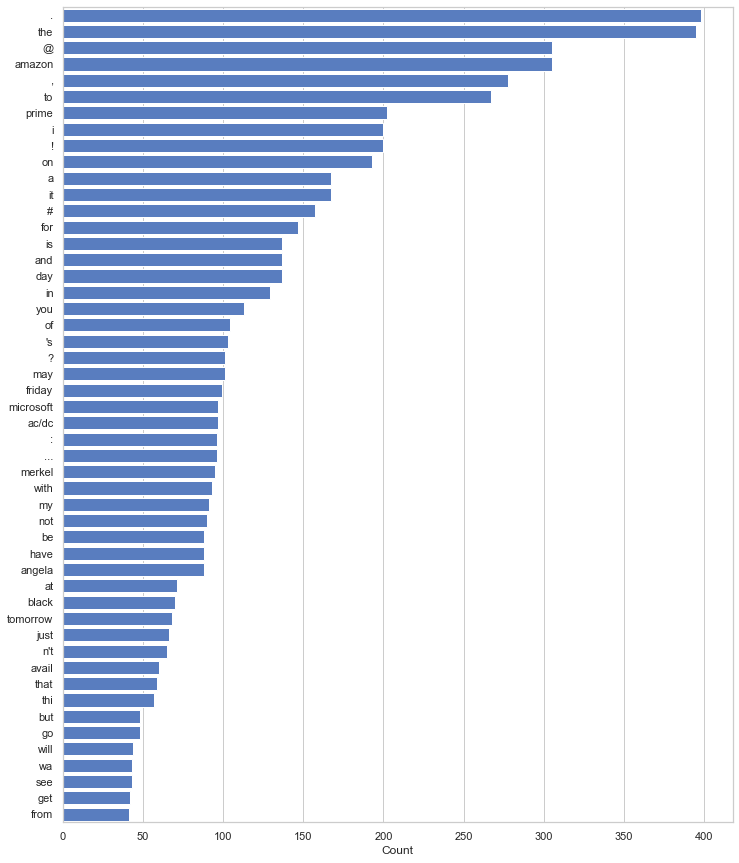

In [13]:
print(words.most_common(50))
show_histogram(words.most_common(50))

# ODPOWIEDŹ
# Wiele z popularnych tokenów to znaki interpunkcyjne albo słowa typu "the", "a", które nie niosą dużo informacji.

Widać, że nie wszystkie tokeny to słowa. Ponieważ budujemy słownik słów, które będą wykorzystywane do klasyfikacji tekstów, usuńmy podstawowe tokeny, które nie niosą żadnej informacji.

**Zad. 6: Usuń znaki interpunkcyjne z kolekcji words i powtórz analizę. Czy w przypadku badania opinii trzeba wyrzucić wszystkie znaki interpunkcyjne?**

[('the', 395), ('amazon', 305), ('to', 267), ('prime', 202), ('i', 200), ('on', 193), ('a', 167), ('it', 167), ('for', 147), ('is', 137), ('and', 137), ('day', 137), ('in', 129), ('you', 113), ('of', 104), ('may', 101), ('friday', 99), ('microsoft', 97), ('merkel', 95), ('with', 93), ('my', 91), ('not', 90), ('be', 88), ('have', 88), ('angela', 88), ('at', 71), ('black', 70), ('tomorrow', 68), ('just', 66), ('avail', 60), ('that', 59), ('thi', 57), ('but', 48), ('go', 48), ('will', 44), ('wa', 43), ('see', 43), ('get', 42), ('from', 41), ('if', 38), ('do', 33), ('so', 32), ('out', 32), ('by', 32), ('me', 31), ('about', 30), ('your', 30), ('deal', 30), ('order', 29), ('up', 29)]


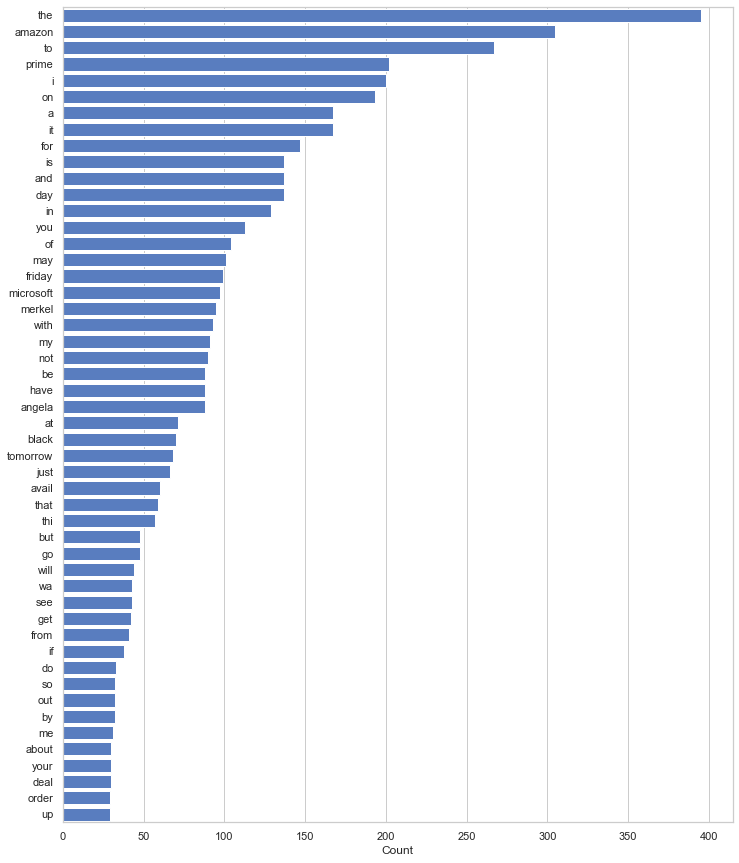

In [14]:
import string 

for word in list(words):
    if not word.isalnum() and RE_EMOTICONS.match(word) is None: 
        del words[word]
    
print(words.most_common(50))
show_histogram(words.most_common(50))

#ODPOWIEDŹ
# Zostawiamy emotikony bo mogą być przydatne w badaniu opini - wyrażają dobrze emocje

Wyraźnie widać, że nawet bez znaków intepunkcyjnych pozostało dużo zbędnych tokenów. Poniżej lista słów, które często są oznaczane jako tzw. stopwords, czyli słowa występujące często a nie niosące informacji.

In [15]:
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "her", "here", "hers", "herself", "him",
            "himself", "his", "how", "i", "in", "into", "is", "it", "its", "itself", "let", "me", "more", "most", "my",
            "myself", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "sha",
            "she", "should", "so", "some", "such", "than", "that", "the", "their", "theirs", "them", "themselves",
            "then", "there", "there's", "these", "they", "this", "those", "through", "to", "until", "up", "very",
            "was", "we", "were", "what", "when", "where", "which", "while", "who","whom", "with", "would", "you",
            "your", "yours", "yourself", "yourselves",
            "n't", "'s", "'ll", "'re", "'d", "'m", "'ve",
            "above", "again", "against", "below", "but", "cannot", "down", "few", "if", "no", "nor", "not", "off",
            "out", "over", "same", "too", "under", "why"]

**Zad. 7: Korzystając z listy `sotpwords` usuń z kolekcji `words` popularne stopwords i ponów analizę. Czy wszystkie stopwords zawsze należy wyrzucać? Czy słowa takie jak "not" mogą być nośnikiem opinii? Jeśli masz jeszcze dużo czasu, możesz przeanalizować listę słów w nltk.corpus.stopwords.words('english')?**

[('amazon', 305), ('prime', 202), ('day', 137), ('may', 101), ('friday', 99), ('microsoft', 97), ('merkel', 95), ('angela', 88), ('black', 70), ('tomorrow', 68), ('just', 66), ('avail', 60), ('thi', 57), ('go', 48), ('will', 44), ('wa', 43), ('see', 43), ('get', 42), ('deal', 30), ('order', 29), ('ha', 28), ('sale', 28), ('time', 27), ('1st', 25), ('one', 25), ('new', 25), ('night', 24), ('now', 23), ('free', 23), ('can', 22), ('2nd', 21), ('got', 21), ('today', 21), ('look', 21), ('3rd', 20), ('like', 20), ('whi', 19), ('come', 19), ('say', 18), ('wednesday', 18), ('want', 18), ('thursday', 18), ('concert', 18), ('make', 17), ('germani', 17), ('us', 16), ('back', 16), ('monday', 16), ('tuesday', 16), ('window', 15)]


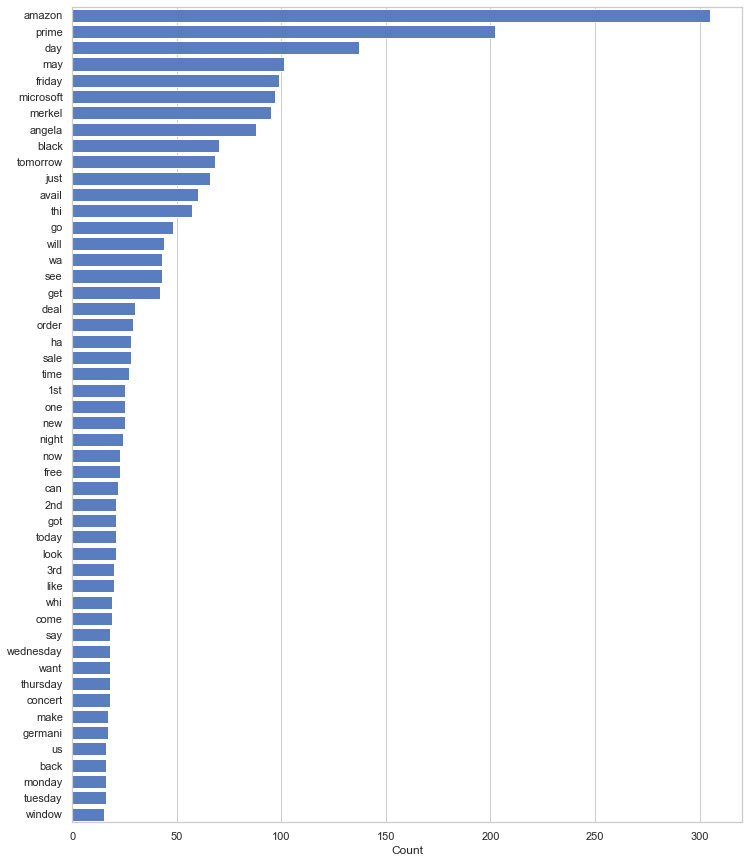

In [16]:
for word in list(words):
    if word in stopwords:
        del words[word]

print(words.most_common(50))
show_histogram(words.most_common(50))

# ODPOWIEDŹ
# Słowa takie jak not mogą być nośnikiem opini. Negatywne opinie intuicyjnie będą zawierać więcej przeczeń.

Oprócz tokenów, które występują zbyt często, problemem bywają również najrzadsze tokeny.

**Zad. 8: Przeanalizuj 100 listę najrzadszych tokenów. Czy wszystkie tokeny są rzeczywiście rzadkie? Czy jakieś typy tokenów powtarzają się? Jak myślisz, co najlepiej zrobić z takimi tokenami jak 1, 2, 3... 10%, 20%, 30%..., 12:00, 19:50, 22:30, ..., 2005, 2010, 1995..., 10\$, 20\$, 30\$... ?**

[('columnista', 1), ('invas', 1), ('organis', 1), ('freedomoffreedo', 1), ('reaganitegop', 1), ('piti', 1), ('restor', 1), ('refugeeswelcom', 1), ('bold', 1), ('inclin', 1), ('shown', 1), ('rare', 1), ('xenophob', 1), ('action', 1), ('critic', 1), ('concern', 1), ('citizen', 1), ('humanitarian', 1), ('graduat', 1), ('newsfusionapp', 1), ('must', 1), ('whole', 1), ('migrantcrisi', 1), ('migrantmarch', 1), ('exodu', 1), ('ran', 1), ('nobodi', 1), ('nishelo', 1), ('exampl', 1), ('sweden', 1), ('colour', 1), ('gunboat', 1), ('sink', 1), ('favour', 1), ('kthopkin', 1), ('snp', 1), ('spain', 1), ('seced', 1), ('reappli', 1), ('catalonia', 1), ('budapest', 1), ('hungari', 1), ('prayer', 1), ('bild', 1), ('22', 1), ('schroeder', 1), ('gerhard', 1), ('predecessor', 1), ('biographi', 1), ('btw', 1), ('googlealert', 1), ('movement', 1), ('principl', 1), ('admitt', 1), ('passport', 1), ('ajweald', 1), ('stood', 1), ('digniti', 1), ('thearkoftwitt', 1), ('foxreg', 1), ('reform', 1), ('zone', 1), ('

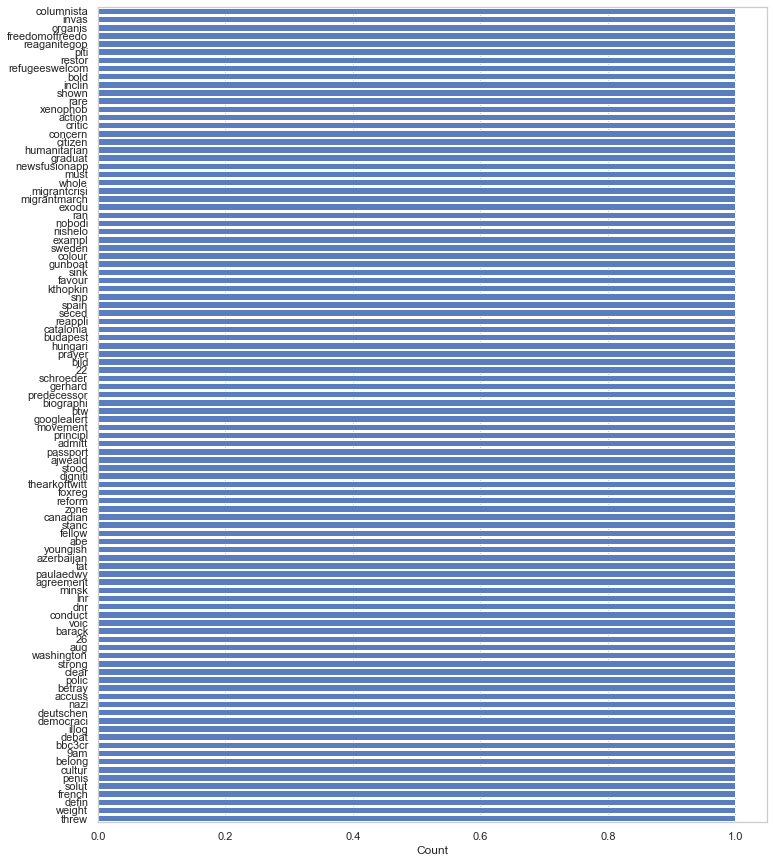

In [17]:
words_rev = list(reversed(words.most_common()))
print(words_rev[:100])
show_histogram(words_rev[:100])

# Wszystkie 100 najrzadszych tokenów to słowa unikalne. Tokeny takie jak 1, 2 itp. najlepiej usunąc
# ponieważ nie niosą one dużo informacji 

# Usuwam unikalne słowa
for word in list(words):
    if words[word] < 2:
        del words[word]
        

Na tym etapie w zmiennej `words` mamy wstępnie przygotowany słownik. Jak widać słownik możnaby jeszcze ulepszyć, ale w tym ćwiczeniu poprzestaniemy na tym co do tej pory zrobiliśmy.

## Klasyfikacja

Mając słownik zamienimy przykłady uczące na reprezentację bag of words (BOW). W tej reprezentacji każdy przykład uczący (pojedynczy dokument tekstowy) przyjmuje formę wektora liczb. Każda pozycja w wektorze oznacza kolejne słowo ze słownika, a liczba na danej pozycji mówi czy (0-1) lub jak często (0-k) dane słowo występuje w tekście. Taka reprezentacja wektorowa ma tę zaletę, że można ją łatwo rozszerzać o dodatkowe atrybuty.

**Zad. 9: Przeanalizuj poniższy kod tworzący reprezentację bag-of-words. Co to jest `csr_matrix`? Czy wykorzystanie tej klasy jest konieczne?**

In [18]:
def create_bow(documents, features):
    row = []
    col = []
    data = []

    labels = []

    for i in documents.index:
        tweet = BeforeTokenizationNormalizer.normalize(documents.iloc[i, 2])
        label = documents.iloc[i, 1]
        tweet_tokens = TweetTokenizer.tokenize(tweet)

        labels.append(label)
        for token in set(tweet_tokens):
            if token not in features:
                continue
            row.append(i)
            col.append(features[token])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(len(documents), len(features))), labels

# ODPOWIEDŹ
# csr_matrix to skompresowana rzadka macierz. Umożliwia szybkie operacje w przypadku rzadkich macierzy.
# Przykład w tej reprezentacji na pewno będzie miał wiele zer,
# ponieważ będzie występować w nim mała część słów z całego słownika

Na koniec wykorzystajmy dotychczasową wiedzę, żeby nauczyć i przetestować klasyfikator.

**Zad. 10: Sprawdź działanie klasyfikatora Random Forest na przetworzonych wcześniej danych. Jak na trafność klasyfikacji wpływa parametr min_word_count?**

In [19]:
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

min_word_count = 5

train_tweets = pd.read_csv("tweets_train.tsv", sep="\t", header=None)
test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
common_words = list([k for k, v in words.most_common() if v > min_word_count])

feature_dict = {}
for word in common_words:
    feature_dict[word] = len(feature_dict)

print("Training classifier...")
X_train, y_train = create_bow(train_tweets, feature_dict)
list_of_labels = list(set(y_train))
classifier = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=23)
classifier.fit(X_train, y_train)

print("Testing...")
test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
X_test, y_test = create_bow(test_tweets, feature_dict)
predicted = classifier.predict(X_test)

print("=================== Results ===================")
print("            Positive    Neutral     Negative   ")
print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))

# Odpowiedź
# Jeżeli zmniejszymy min_word_count (mniejsze niz 5) to klasyfikator źle radzi sobie z rozróżnianiem pozytywnych opini.
# Jeżeli zwiększymy, np do 20 to źle radzimy sobie z rozróznianiem klasy negatwynej.
# Skuteczność rozpoznawania negatywnych komentarzy widocznie zależy od jakiś słów, które są stosunkowo rzadkie

Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.72324723 0.22222222 0.35714286]
Precision [0.67123288 0.25       0.42553191]
Recall    [0.784      0.2        0.30769231]
